## **Introduction**
Customer churn, the phenomenon where customers stop engaging with a business, is a critical challenge faced by all customer-oriented industries, including gambling operators. In a highly competitive market, retaining customers is often more cost-effective than acquiring new ones. This makes customer retention strategies essential for businesses looking to maintain and grow their customer base. By identifying players who are likely to churn, gambling operators can proactively engage with them through personalized offers and promotions, thus reducing churn rates, increasing customer loyalty, and enhancing revenue.

The task of predicting customer churn involves analyzing player behavior using historical data. Businesses can use predictive modeling to flag potential churners, allowing the CRM (Customer Relationship Management) team to intervene before the player decides to leave. Such a proactive approach to customer retention could help create a more stable customer base and enhance long-term business growth. The primary goal of this project is to build a predictive model that identifies players who are likely to churn, based on daily aggregations of their activity.

The dataset available for this project consists of information on around 7,000 players who made their first deposit within a specific calendar year. For each player, daily aggregation data is available across various features, such as the number of bets placed, total turnover, approved deposits and withdrawals, net gaming revenue (NGR), and the total number and length of gaming sessions. Additionally, data is broken down by vertical, providing insights into different categories of games (e.g., sports, live casino, classic casino). The goal is to define a target variable for churn prediction and develop a machine learning model that can reliably predict which customers are likely to churn.

In this context, churn can be defined as a player who becomes inactive for a certain period (e.g., 30 days without any activity). This is a relevant target to predict because once a player churns, it becomes more difficult and expensive to re-engage them. Early identification of at-risk customers allows for the deployment of retention strategies, such as sending personalized offers or promotions, which can mitigate churn.

The steps involved in building the predictive model include data cleaning, feature engineering, and selecting appropriate machine learning algorithms. We will explore both traditional models (e.g., Logistic Regression, Random Forest) and more advanced techniques (e.g., XGBoost, LightGBM) to compare their performance. The performance of these models will be evaluated based on metrics such as precision, recall, and F1-score, which are critical for assessing the effectiveness of the churn prediction model. The ultimate goal is to build a model that can be easily interpreted and explained to stakeholders, enabling them to take informed actions to retain valuable customers.

In summary, this project aims to use machine learning to predict customer churn, allowing businesses to take a data-driven approach to customer retention. By identifying players at risk of leaving, gambling operators can reduce churn, foster customer loyalty, and ultimately improve their bottom line.



## **1. Importing Libraries**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import auc

pandas: For data manipulation.

scikit-learn: For model building and evaluation.

XGBoost and LightGBM: Advanced gradient-boosting models.

matplotlib and seaborn: For data visualization.

sklearn.metrics: For evaluating model performance (confusion matrix, ROC curve, etc.).

## **2. Loading and Preprocessing Data**

In [2]:
df = pd.read_excel('data.xlsx')
df.fillna(0, inplace=True)
df = pd.get_dummies(df, columns=['vertical'])

The dataset is loaded using pandas. Missing values are filled with 0.
Categorical variables like vertical are one-hot encoded using get_dummies() to convert them into numerical form.

## **3. Defining Target Variable (Churn)**

In [3]:
from datetime import datetime
df['date'] = pd.to_datetime(df['date'])
cutoff_date = df['date'].max() - pd.DateOffset(days=30)
df['churn'] = df['date'].apply(lambda x: 1 if x < cutoff_date else 0)

The date field is converted to a datetime format.
A churn target variable is created based on a 30-day inactivity rule. If a player’s last activity is more than 30 days before the most recent date in the dataset, they are considered churned (labeled 1), otherwise 0.

## **4. Churn Distribution Pie Chart**

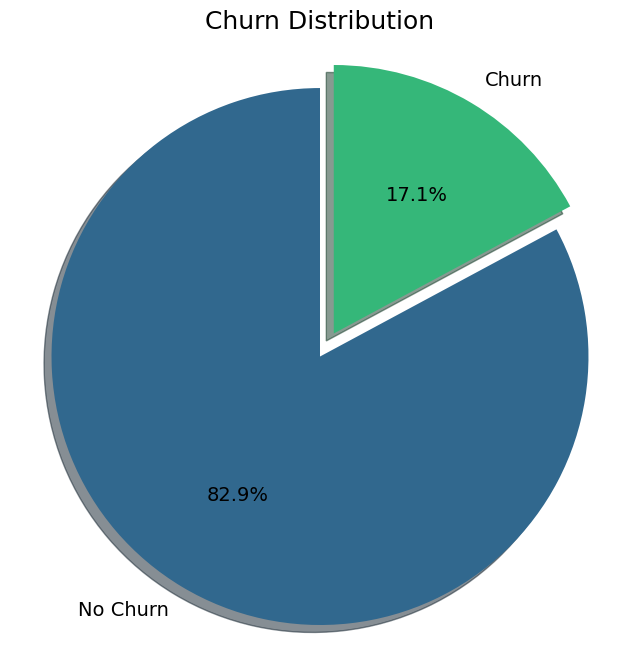

In [4]:
plt.figure(figsize=(8, 8))

colors = sns.color_palette('viridis', 2)
churn_counts = df['churn'].value_counts()

plt.pie(churn_counts, 
        labels=['No Churn', 'Churn'], 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=colors, 
        explode=(0.05, 0.05),
        shadow=True, 
        textprops={'fontsize': 14})

plt.title('Churn Distribution', fontsize=18)
plt.axis('equal')
plt.show()

This part generates a pie chart showing the distribution of churned vs. non-churned customers. The explode parameter separates the two segments slightly, and the autopct displays percentages.

Helps to quickly gauge the imbalance between churn and non-churn customers.

## **5. Correlation Matrix**

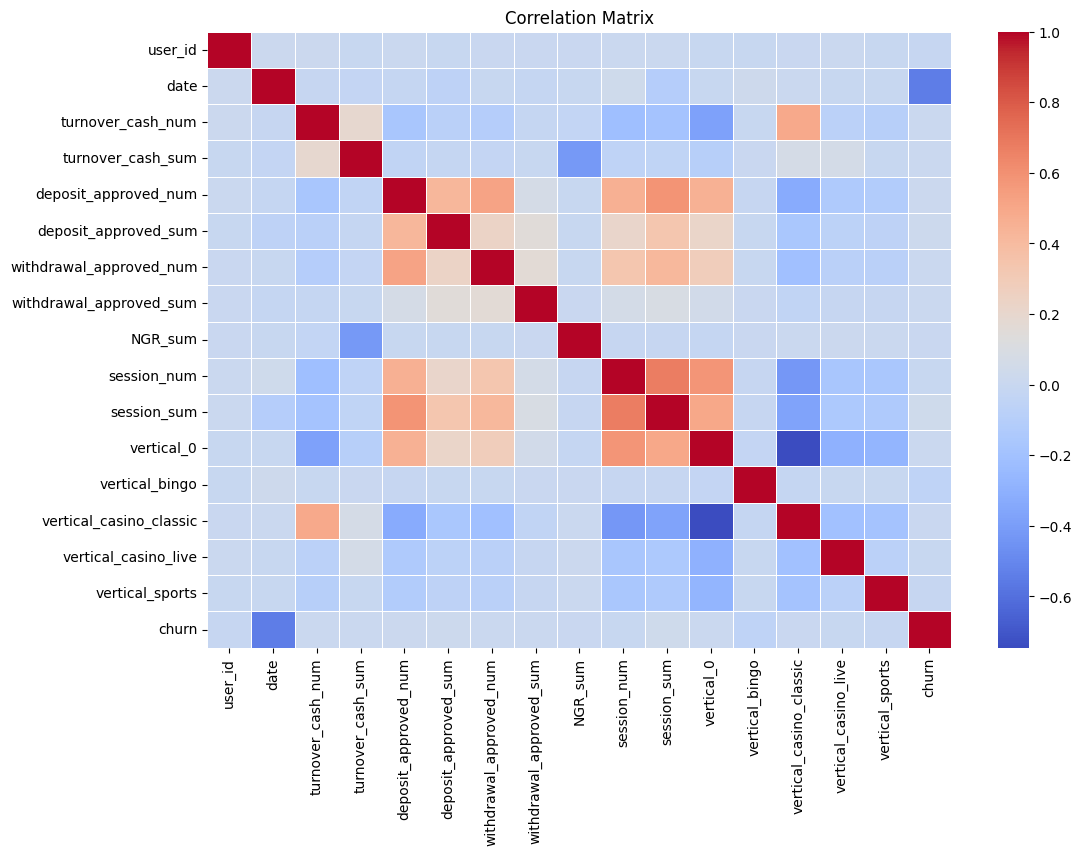

In [5]:
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

A correlation matrix is plotted to visualize relationships between features. This helps in understanding which features are correlated with each other.

Helps identify relationships between features (e.g., highly correlated features).

Can indicate multicollinearity, which could influence the choice of features in the model.

Helps identify which features might be more related to the churn target.

## **6. Feature Distributions**

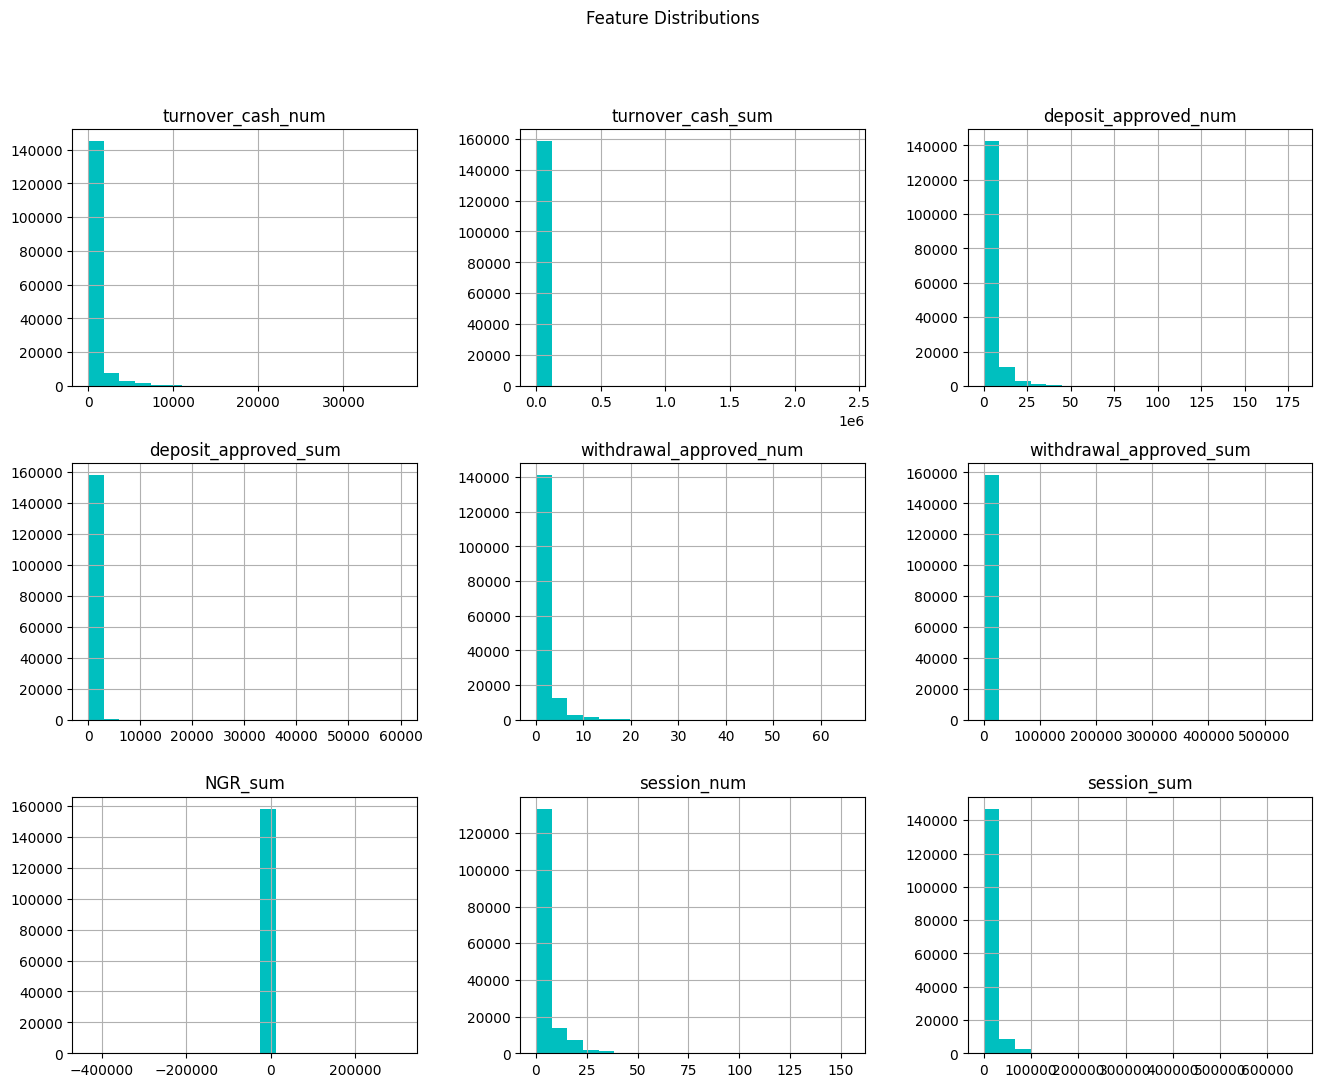

In [6]:
numeric_columns = ['turnover_cash_num', 'turnover_cash_sum', 'deposit_approved_num',
                   'deposit_approved_sum', 'withdrawal_approved_num', 'withdrawal_approved_sum',
                   'NGR_sum', 'session_num', 'session_sum']

df[numeric_columns].hist(figsize=(16, 12), bins=20, color='c')
plt.suptitle('Feature Distributions')
plt.show()

This generates histograms for the distribution of numeric features. It provides insights into the shape and spread of each feature’s data.

Helps understand the spread, skewness, and range of each feature.

Identifies any potential outliers or unusual patterns in the data.

Allows you to see if the features are normally distributed, which is important for some machine learning models.

## **7. Box Plots for Churn vs. Features**

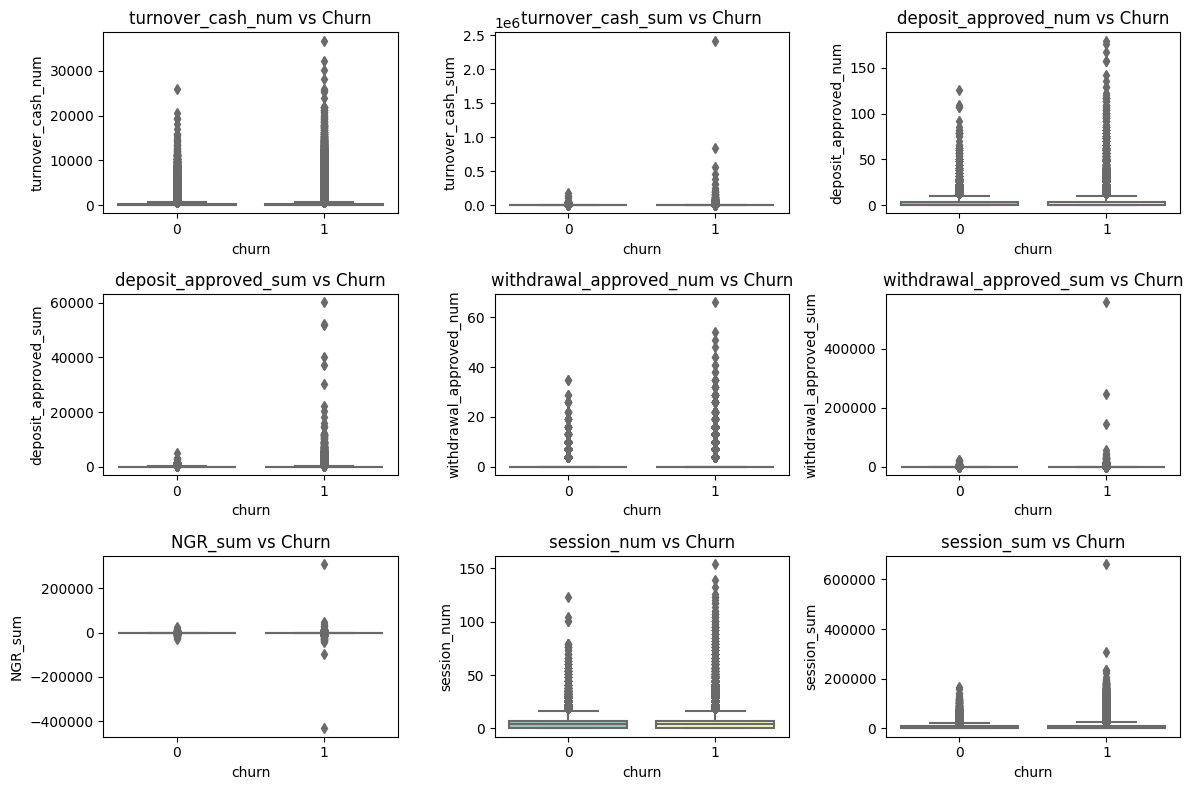

In [7]:
plt.figure(figsize=(12, 8))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='churn', y=column, data=df, palette='Set3')
    plt.title(f'{column} vs Churn')
    plt.tight_layout()
plt.show()

Box plots are used to analyze how each numeric feature relates to churn. This helps in visualizing differences in feature values for churned and non-churned customers.

Helps assess whether there is a significant difference between churned and non-churned customers for each feature.

If a feature has a clear separation between the two classes, it may be an important predictor of churn.

Identifies the presence of outliers and whether certain features have a wide or narrow range of values for churned versus non-churned customers.

## **8. Train-Test Split and Scaling**

In [8]:
X = df.drop(['user_id', 'date', 'churn'], axis=1)
y = df['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

The features (X) are separated from the target (y).
The data is split into training and test sets (70% training, 30% testing).
Standard scaling is applied to normalize the features, which is essential for models like logistic regression and gradient boosting.

## **9. Model Training**

In [9]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier()
}

Four models are defined: Logistic Regression, Random Forest, XGBoost, and LightGBM. These models are representative of linear, ensemble, and gradient boosting methods.

## **10. Model Evaluation and Visualization**

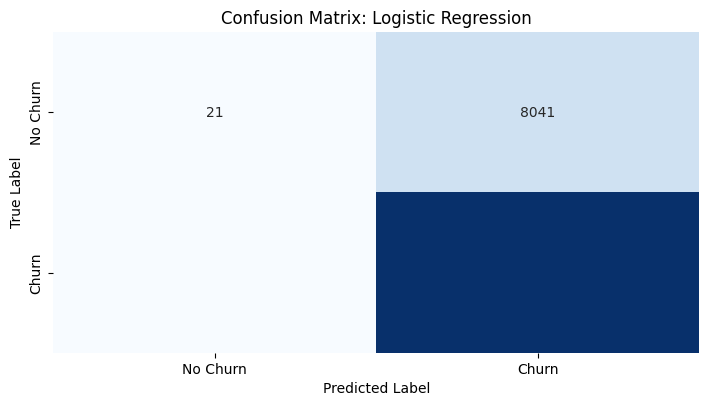

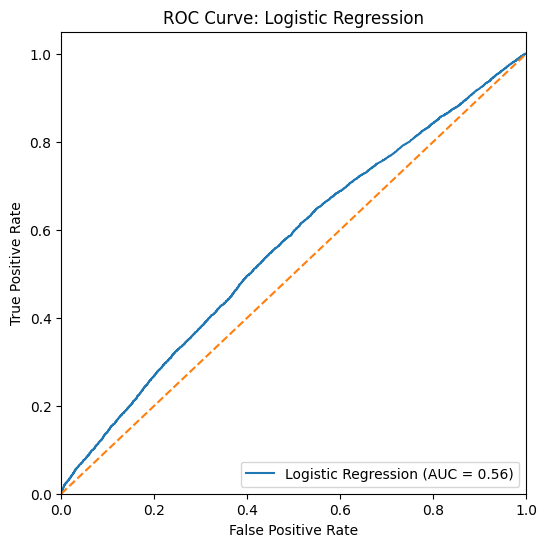

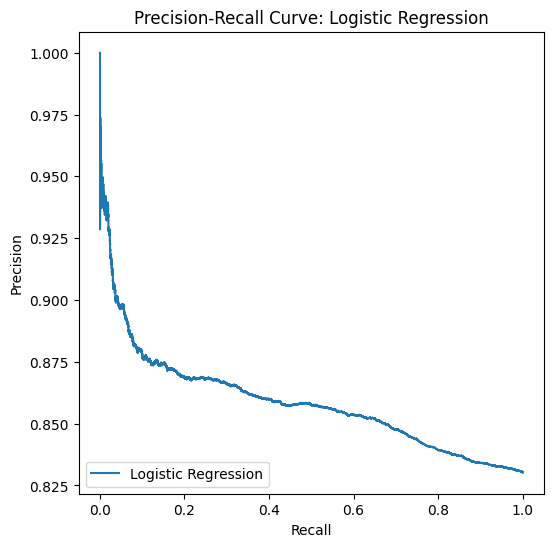

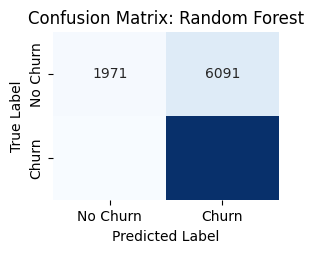

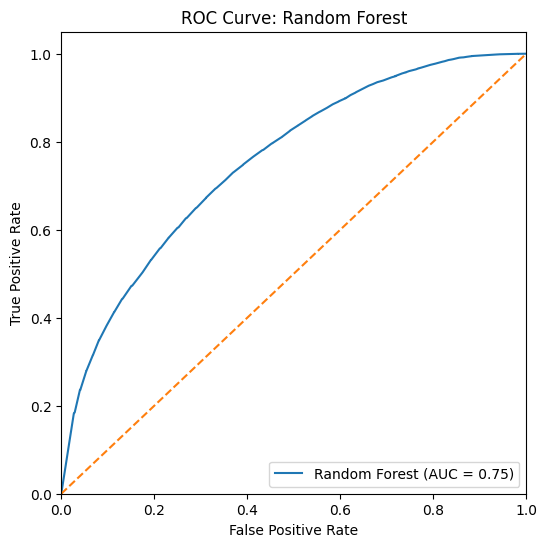

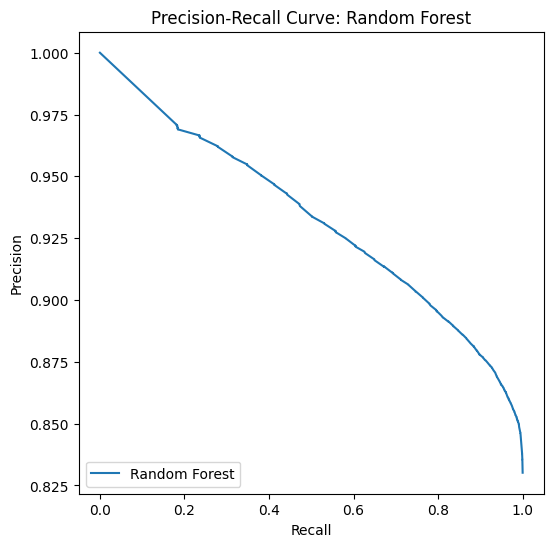

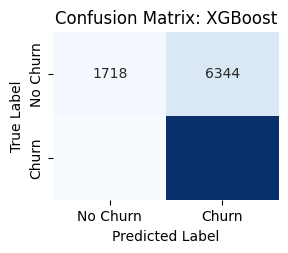

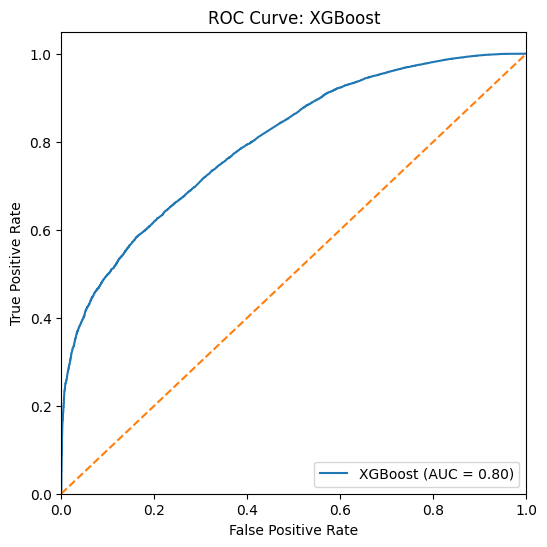

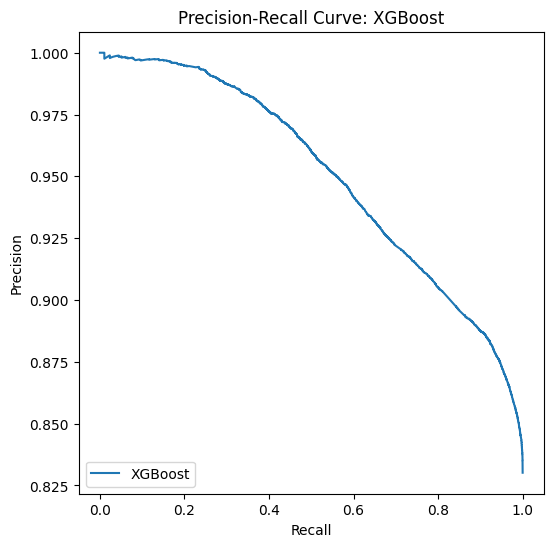

[LightGBM] [Info] Number of positive: 91683, number of negative: 19068
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1637
[LightGBM] [Info] Number of data points in the train set: 110751, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.827830 -> initscore=1.570325
[LightGBM] [Info] Start training from score 1.570325


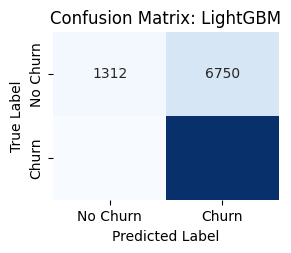

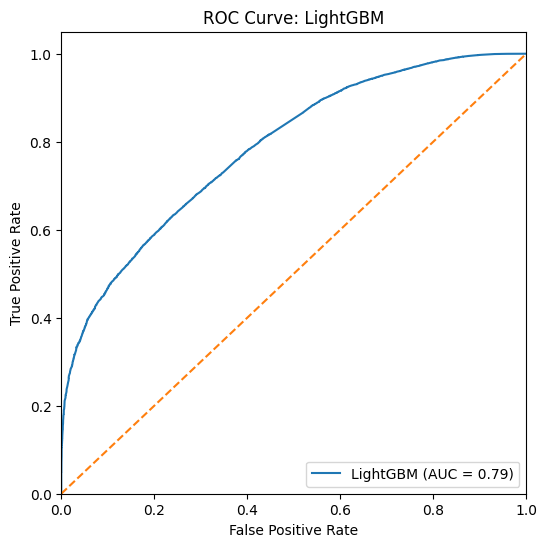

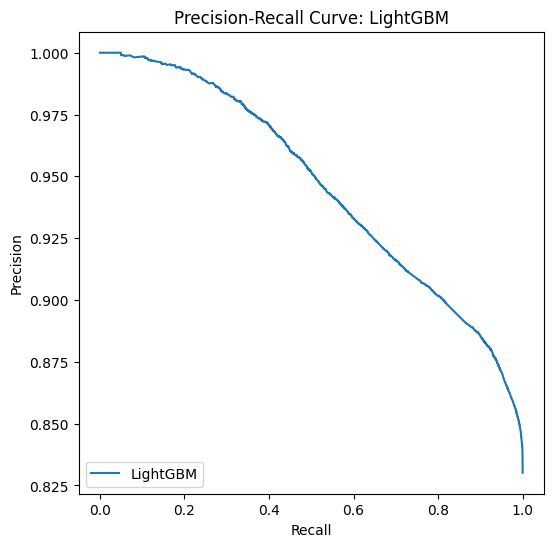

In [13]:
results = {}
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i, (model_name, model) in enumerate(models.items(), 1):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    results[model_name] = {
        'confusion_matrix': conf_matrix,
        'classification_report': report
    }
    
    plt.subplot(2, 2, i)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
                xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, label=f'{model_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {model_name}')
    plt.legend(loc="lower left")
    plt.show()

**For each model:**

The model is trained using the training data.

Confusion matrix: The predictions are evaluated using a confusion matrix, plotted as a heatmap.

ROC Curve: Shows the trade-off between the true positive rate and false positive rate.

Precision-Recall Curve: Visualizes the relationship between precision and recall.

-------------------------------------------------------------------------------------------------------------

**1. Confusion Matrix**

The confusion matrix is a table that summarizes the performance of a classification model by comparing predicted labels to the true labels. It breaks down the predictions into four categories:

True Positives (TP): Correctly predicted positive cases (e.g., predicted churn, actual churn).

True Negatives (TN): Correctly predicted negative cases (e.g., predicted no churn, actual no churn).

False Positives (FP): Incorrectly predicted positive cases (e.g., predicted churn, but no churn).

False Negatives (FN): Incorrectly predicted negative cases (e.g., predicted no churn, but churn occurred).

The overall accuracy can be calculated by the sum of TP and TN divided by the total number of predictions.
Helps identify whether the model is better at predicting one class over the other. For example, if there are many false negatives, the model misses a lot of churn cases.
Useful in understanding how well the model handles class imbalance, especially when one class is much larger than the other.

-------------------------------------------------------------------------------------------------------------

**2. ROC Curve (Receiver Operating Characteristic Curve)**

The ROC curve is a graphical representation that shows the trade-off between the True Positive Rate (TPR) (sensitivity) and False Positive Rate (FPR) across different classification thresholds.

True Positive Rate (TPR) (also known as recall) = TP / (TP + FN)

False Positive Rate (FPR) = FP / (FP + TN)

The closer the ROC curve is to the top-left corner, the better the model is at distinguishing between the classes. The area under the ROC curve (AUC) provides a single value to summarize the model's performance:

AUC = 1.0: Perfect model.

AUC = 0.5: Model performs no better than random guessing.

AUC closer to 1: Indicates better model performance.

Shows how different threshold settings affect the sensitivity and specificity of the model.
AUC Score, Helps to compare the overall performance of multiple models; a higher AUC indicates better distinguishing capability.

-------------------------------------------------------------------------------------------------------------

**3. Precision-Recall Curve**

The Precision-Recall curve plots Precision against Recall for different classification thresholds. These metrics are particularly useful when dealing with imbalanced datasets:

Precision = TP / (TP + FP): How many of the predicted positives are actual positives.

Recall = TP / (TP + FN): How many of the actual positives were correctly predicted.

The curve shows the trade-off between precision and recall as the threshold changes:

Higher Precision: Fewer false positives but may miss true positives.

Higher Recall: Captures more true positives but may also include more false positives.

The area under the Precision-Recall curve (AUC-PR) can also be used to summarize the model's performance, especially in imbalanced datasets where AUC-ROC might give a misleading picture.


More informative when dealing with imbalanced datasets where the ROC curve can be less useful due to class imbalance.
Allows you to choose the appropriate threshold based on whether you want to prioritize high precision (few false positives) or high recall (few false negatives).

## **11. Displaying Results**

In [14]:
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    print("\nClassification Report:")
    print(result['classification_report'])
    print("\n" + "="*50 + "\n")

Model: Logistic Regression
Confusion Matrix:
[[   21  8041]
 [    9 39394]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.00      0.01      8062
           1       0.83      1.00      0.91     39403

    accuracy                           0.83     47465
   macro avg       0.77      0.50      0.46     47465
weighted avg       0.81      0.83      0.75     47465



Model: Random Forest
Confusion Matrix:
[[ 1971  6091]
 [ 1473 37930]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.24      0.34      8062
           1       0.86      0.96      0.91     39403

    accuracy                           0.84     47465
   macro avg       0.72      0.60      0.63     47465
weighted avg       0.81      0.84      0.81     47465



Model: XGBoost
Confusion Matrix:
[[ 1718  6344]
 [  853 38550]]

Classification Report:
              precision    recall  f1-score   support

     

The confusion matrix and classification report (which includes precision, recall, F1-score) are printed for each model.

**Summary**

This code provides a complete workflow for:

Data preprocessing (handling missing data, one-hot encoding, scaling).

Data visualization (churn distribution, feature relationships, correlation matrix).

Model training using four different machine learning algorithms.

Model evaluation with confusion matrices, ROC curves, and precision-recall curves.

This allows for a thorough understanding of the data and model performance, with plots to visualize important steps and results.


## **Performance Analysis of Models:**

**1. Logistic Regression:**

Confusion Matrix:

True Negatives (No Churn predicted correctly): 21

False Positives (No Churn incorrectly predicted as Churn): 8041

True Positives (Churn predicted correctly): 39,394

False Negatives (Churn incorrectly predicted as No Churn): 9

Metrics:

Precision (Class 1): 0.83

Recall (Class 1): 1.00

F1-Score (Class 1): 0.91

Accuracy: 0.83

The model is excellent at identifying churned customers (Class 1) but struggles heavily with predicting non-churned customers (Class 0). This results in a high recall for Class 1 but poor performance for Class 0, indicating that Logistic Regression might not be suitable for balanced performance across both classes.

-------------------------------------------------------------------------------------------------------------

**2. Random Forest:**

Confusion Matrix:

True Negatives: 1,971

False Positives: 6,091

True Positives: 37,930

False Negatives: 1,473

Metrics:

Precision (Class 1): 0.86

Recall (Class 1): 0.96

F1-Score (Class 1): 0.91

Accuracy: 0.84

The Random Forest model shows a better balance between precision and recall. It identifies a higher number of non-churned customers compared to Logistic Regression but still struggles with Class 0, having a recall of only 0.24.

-------------------------------------------------------------------------------------------------------------

**3. XGBoost:**

Confusion Matrix:

True Negatives: 1,718

False Positives: 6,344

True Positives: 38,550

False Negatives: 853

Metrics:

Precision (Class 1): 0.86

Recall (Class 1): 0.98

F1-Score (Class 1): 0.91

Accuracy: 0.85

XGBoost performs better than Random Forest in terms of recall for Class 1, while maintaining a reasonable performance for Class 0. This makes it slightly better at handling imbalance, although it still struggles to accurately predict non-churned customers.

-------------------------------------------------------------------------------------------------------------

**4. LightGBM:**
Confusion Matrix:


True Negatives: 1,312

False Positives: 6,750

True Positives: 38,965

False Negatives: 438

Metrics:

Precision (Class 1): 0.85

Recall (Class 1): 0.99

F1-Score (Class 1): 0.92

Accuracy: 0.85

LightGBM performs similarly to XGBoost but has slightly better recall for churned customers (Class 1). However, it has the highest number of false positives, leading to a low recall for non-churned customers (Class 0).

-------------------------------------------------------------------------------------------------------------

Best Model: XGBoost and LightGBM both outperform Logistic Regression and Random Forest in this scenario, with LightGBM having slightly better recall for churn detection.